In [34]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices
using KrylovKit, IterTools, FFTW
using Dierckx

Random.seed!(123);

include("RHMatrix.jl")

Main.RHMatrix

In [35]:
# important functions
include("localization3d.jl")


SL (generic function with 1 method)

In [36]:
#=
""" 
    respline(x, y, N)

Use a 2D parametric B-spline to interpolate the closed curve to N points

# Arguments
- `x`: vector of x-coordinates
- `y`: vector of y-coordinates
- `N`: number of desired output points

# Outputs
- a matrix of size 2 x N in [y, x] order containing the splined coordinates

"""
function respline(x, y, N)
    ps = ParametricSpline(vcat(y', x'); s=0.0)
    return evaluate(ps,  LinRange(0, 1, N))
end

""" Spline all curves to have the same number of points """
equalNclosedcurve(thpha, N) = map(thph -> (length(thph) == N) ? thph : hcat(thph[1,1]*ones(N), respline(thph[:,3], thph[:,2], N)'), thpha)
=#

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)
- each contour has the same number of points (if not, you have to spline the boundary and interpolate, which is not hard), and the same orientation

We will just stack a bunch of blobs.

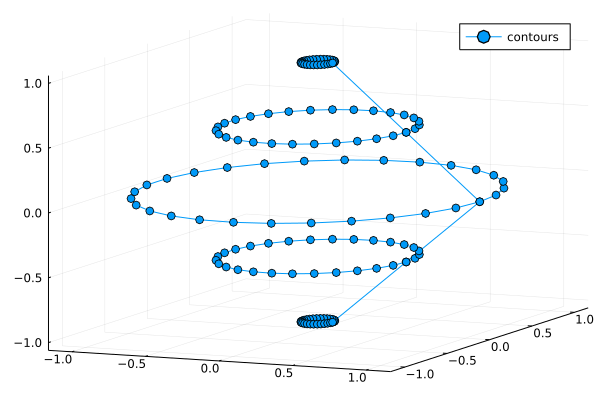

In [81]:
Nz = 5
# x, y = blob(Nz,5)
t = LinRange(0, 1, 30)
x, y = cos.(2*pi*t), sin.(2*pi*t)
N = 100

z = collect(-2:2)/2

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
# thpha = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)
thpha = map(i -> hcat(ones(length(y))*z[i], (1.1-abs(z[i]))*y, (1.1-abs(z[i]))*x), 1:Nz)

# ind = vcat(collect(1:2:100), 100)

# Shorten the second closed curve
# thpha[2] = hcat(thpha[2][ind, 1], thpha[2][ind, 2], thpha[2][ind, 3])

# println(size(thph))
thph = vcat(thpha...)
# This is necessary to close the curve
#thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", marker = :o)

In [82]:
thpha_new = equalNclosedcurve(thpha, N);

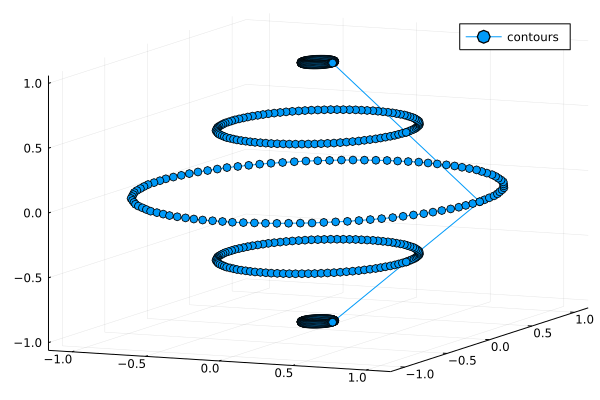

In [83]:
thph_new = vcat(thpha_new...)
p = plot(thph_new[:,3], thph_new[:,2], thph_new[:,1], label = "contours", marker = :o)

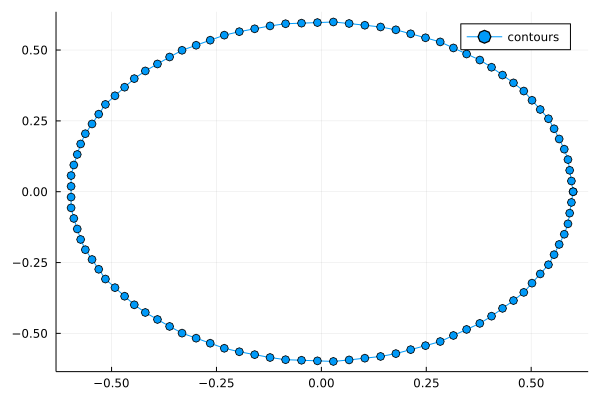

In [84]:
p = plot(thpha_new[2][:,3], thpha_new[2][:,2], label = "contours", marker = :o)

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [126]:
Nqx = Nqy = 16
Nqz = 10

# set parameters for the integration

M  = 3
Kp = [4.0]
szs = int = (Nqx, Nqy, Nqz)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

256

In [127]:
# compute the nodes - first scale in z
colf, th, wqz = scale_quad_nodez(Nqz, z)

([1, 1, 1, 2, 2, 3, 3, 4, 4, 4], [-0.9739065285171717, -0.8650633666889845, -0.6794095682990244, -0.4333953941292472, -0.1488743389816312, 0.1488743389816312, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717], [0.06667134430868821, 0.14945134915058048, 0.21908636251598207, 0.2692667193099964, 0.2955242247147528, 0.2955242247147528, 0.2692667193099964, 0.21908636251598207, 0.14945134915058048, 0.06667134430868821])

In [128]:
newcurve, pkg = fill2d(z, colf, thpha_new, th, Nqx, Nqy)

(LinearAlgebra.Adjoint{Float64,Array{Float64,2}}[[-0.9739065285171717 0.0 0.12609347148282835; -0.9739065285171717 0.007940249526258531 0.1252299173064265; … ; -0.9739065285171717 -0.007940249526258533 0.12522991730642652; -0.9739065285171717 -3.088399324896476e-17 0.12609347148282835], [-0.8650633666889845 0.0 0.23493663331101555; -0.8650633666889845 0.014794227404569534 0.2333276641193541; … ; -0.8650633666889845 -0.014794227404569512 0.23332766411935413; -0.8650633666889845 -5.754287919735813e-17 0.23493663331101555], [-0.6794095682990244 0.0 0.42059043170097565; -0.6794095682990244 0.026485058558462615 0.4177100079995829; … ; -0.6794095682990244 -0.026485058558462553 0.4177100079995829; -0.6794095682990244 -1.0301494518692066e-16 0.42059043170097565], [-0.4333953941292472 0.0 0.6666046058707529; -0.4333953941292472 0.041976851328800274 0.6620393481723257; … ; -0.4333953941292472 -0.0419768513288002 0.6620393481723257; -0.4333953941292472 -1.6327103937530009e-16 0.6666046058707529],

In [129]:
# collate nodes weights
no, sqwt, ev = getnodeswts3d(szs, pkg, th, wqz)

([(-0.017926013243805147, -0.12452977361588856, -0.9739065285171717), (-0.017178778965041108, -0.12452977361588856, -0.9739065285171717), (-0.015862809553864522, -0.12452977361588856, -0.9739065285171717), (-0.014025362519000023, -0.12452977361588856, -0.9739065285171717), (-0.011732809975111651, -0.12452977361588856, -0.9739065285171717), (-0.009068001425214946, -0.12452977361588856, -0.9739065285171717), (-0.006127246743179469, -0.12452977361588856, -0.9739065285171717), (-0.0030168310051661533, -0.12452977361588856, -0.9739065285171717), (0.00015082811089606185, -0.12452977361588856, -0.9739065285171717), (0.003261243848909374, -0.12452977361588856, -0.9739065285171717)  …  (-0.006127246743179176, 0.12452977361588854, 0.9739065285171717), (-0.003016831005165869, 0.12452977361588854, 0.9739065285171717), (0.00015082811089633594, 0.12452977361588854, 0.9739065285171717), (0.003261243848909641, 0.12452977361588854, 0.9739065285171717), (0.0062019985309451076, 0.12452977361588854, 0.973

In [89]:
#=
    s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
            sqwt = sqwt, int = nothing, ev = ev);
=#

In [90]:
# or you can do it all in one shot, without intermediates:
maxrank = 256
s, sl = slepian3(szs, z, thpha; 
                M = 3, Kp = [4.0], prec = 1e-8, exact = false, lvl = 6, 
                    maxrank = 256, int = nothing)

(Complex{Float64}[130.90271861622537 + 0.0im, 104.7862160881175 + 0.0im, 77.22930606762961 + 0.0im, 53.582275512970995 + 0.0im, 47.90930762602862 + 0.0im, 45.37718684399556 + 0.0im, 31.580516418488358 + 0.0im, 27.164093437563427 + 0.0im, 25.86257978332443 + 0.0im, 21.66463204661566 + 0.0im, 18.12622631933003 + 0.0im, 10.670576338915891 + 0.0im], Array{Complex{Float64},3}[[-0.011082705796963577 + 0.0im -0.011287371417320911 + 0.0im … -0.011287371577311505 + 0.0im -0.01108270591235424 + 0.0im; -0.01079251746240782 + 0.0im -0.009785490723680092 + 0.0im … -0.00978549077482616 + 0.0im -0.010792517572145074 + 0.0im; … ; -0.010778010059237113 + 0.0im -0.009729936439022004 + 0.0im … -0.009729936465093372 + 0.0im -0.01077800997668456 + 0.0im; -0.011098992099130883 + 0.0im -0.011269853348124172 + 0.0im … -0.011269853571664358 + 0.0im -0.01109899209354644 + 0.0im]

[-0.010072494133975837 + 0.0im -0.009359006815824905 + 0.0im … -0.009359007013967241 + 0.0im -0.010072494135973057 + 0.0im; -0.008764

# Sanity plot 1 - scaled quadrature points in z

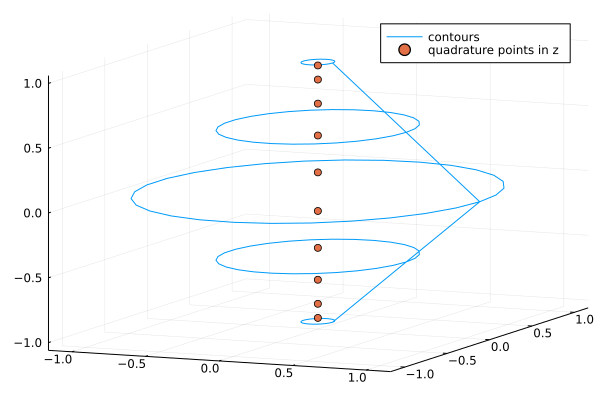

In [91]:
p1 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p1, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")

# Sanity plot II: Show the quadrature closed curves at each z level

Get the (x,y) values at each quadrature level z. 

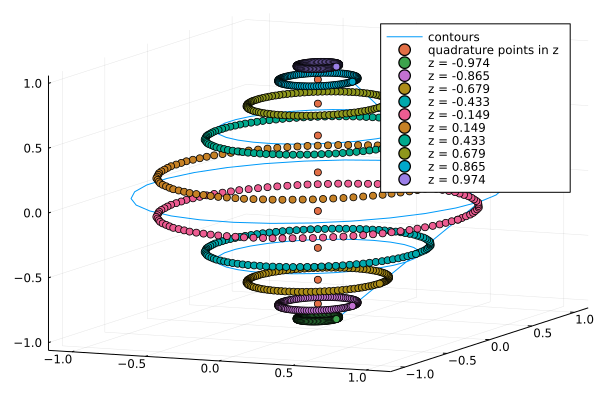

In [92]:
p2 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p2, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")
for i = 1:length(th)
    scatter!(p2, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p2

# Sanity plots III - IV: plot in 2D the quadrature nodes we are getting at each level.

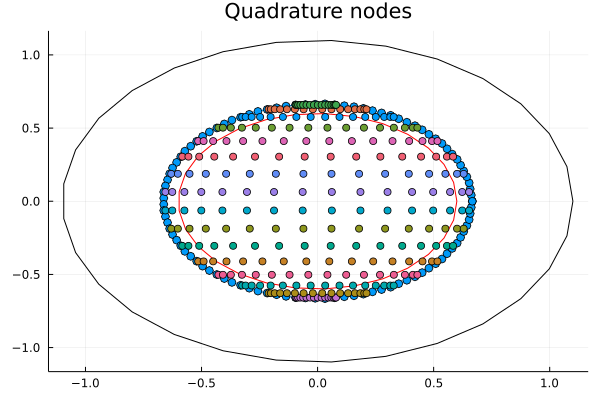

In [93]:
i = 4
N=100
q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")


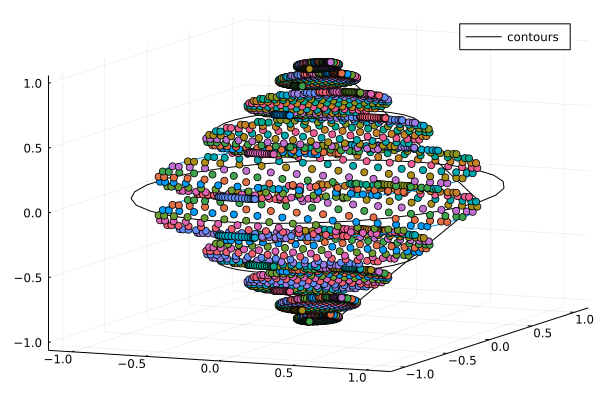

In [94]:
p3 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
for i = 1:10
    plot!(p3, newcurve[i][:,3], newcurve[i][:,2], ones(size(newcurve[i][:,2]))*th[i], c = 1, label = "")
    scatter!(p3, pkg[i][1], pkg[i][2], ones(Nqx,Nqy+1)*th[i] , label = "")
end
p3

# Sanity plot V - Show the sequences

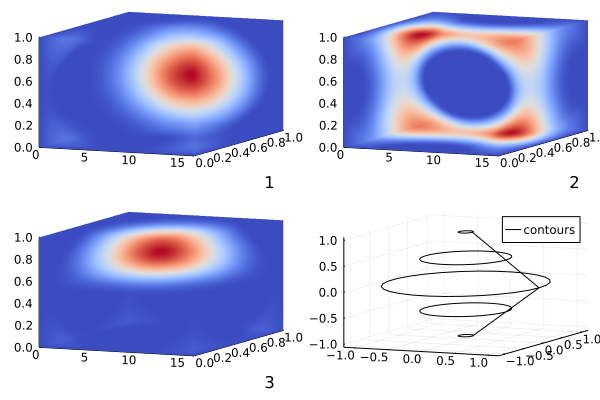

In [95]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ssl = SL(sl)
ran = 1:3
for i = ran
    p1[i] = heatmap( Float64.(sl[i]),
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    #plot!(p1[i], x[1], y[1], legend = false, c = :black)

    # ssl = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(ssl[i]), ylabel = i)
end

psimple = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
plot(p1[1:3]..., psimple)

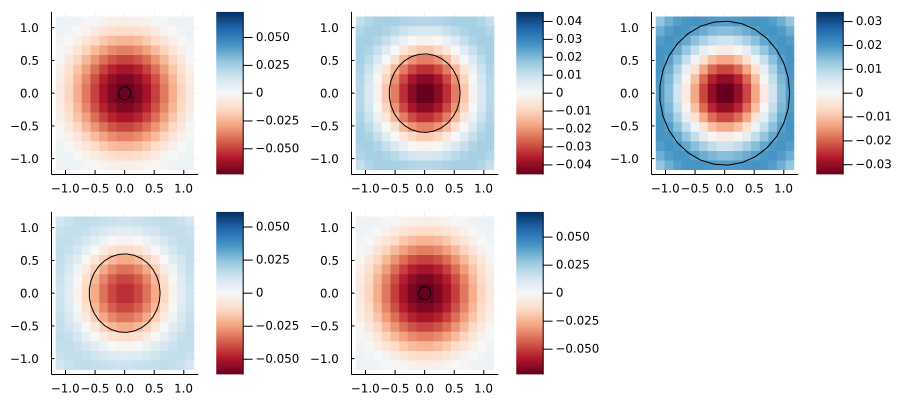

In [117]:
j = 2
ind = [1, 4, 5, 7, 10]
p2dheat = Array{Plots.Plot{Plots.GRBackend},1}(undef, 5)
for i = 1:5
    p2dheat[i] = heatmap(range(minimum(thph[:,3]), maximum(thph[:,3]), length = szs[1]), 
         range(minimum(thph[:,2]), maximum(thph[:,2]), length = szs[2]), 
         Float64.(sl[j][:,:,ind[i]]), c = :RdBu, 
         clims = (-maximum(abs.(Float64.(sl[j][:,:,2*i]))), maximum(abs.(Float64.(sl[j][:,:,2*i])))
    )
    )
    plot!(p2dheat[i], thpha[i][:,3], thpha[i][:,2], c = :black, legend = false)
end

plot(p2dheat..., size=(900, 400))

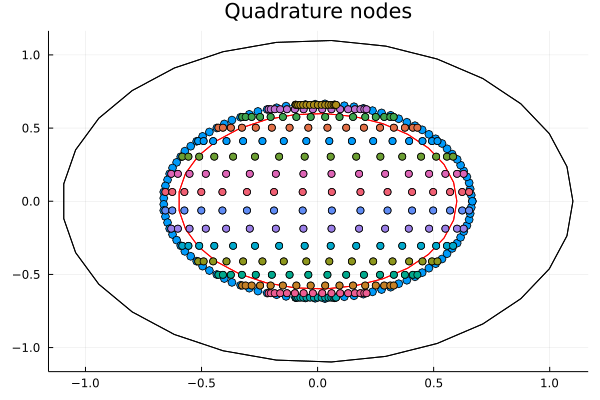

In [97]:
heatmap(range(minimum(thph[:,3]), maximum(thph[:,3]), length = szs[1]), 
         range(minimum(thph[:,2]), maximum(thph[:,2]), length = szs[2]), Float64.(sl[1][:,:,1]))

plot!(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")

# Sanity plot VI: Show the FFTs

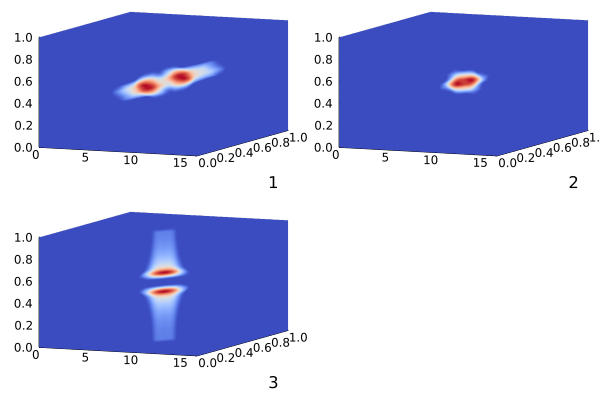

In [116]:
plot(p2[ran]...)

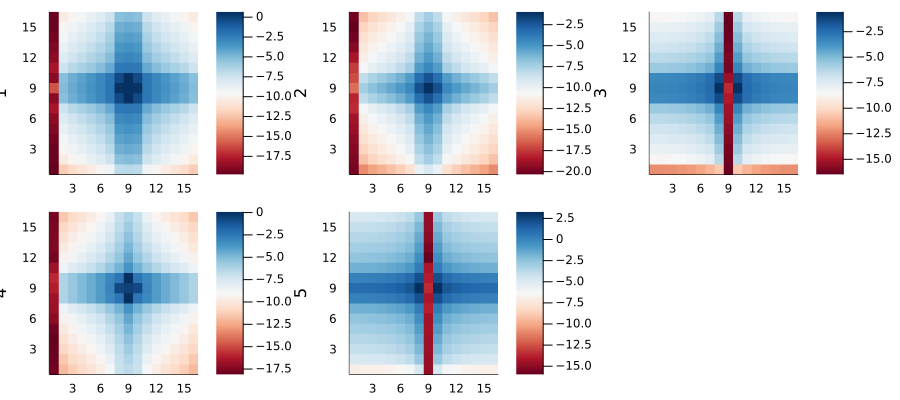

In [121]:
j = 2
ind = [1, 4, 5, 7, 10]
p2dheatspec = Array{Plots.Plot{Plots.GRBackend},1}(undef, 5)
for i = 1:5
    p2dheatspec[i] = heatmap(log10.(ssl[i][:,:,i]), ylabel = i, c = :RdBu, 
        # clims = )
    )
    #plot!(p2dheatspec[i], thpha[i][:,3], thpha[i][:,2], c = :black, legend = false)
end

plot(p2dheatspec..., size=(900, 400))